<a href="https://colab.research.google.com/github/Mastroiani/TCC/blob/Sandbox/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install plotly
!pip install graphviz
!pip install scikit-plot

In [4]:
pip install imbalanced-learn

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import imblearn
print(imblearn.__version__)

0.4.3


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image  
import pydotplus
import pickle

import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.externals.six import StringIO
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

# Funções

In [8]:
def pr_curve(ml):
  y_probas = ml.predict_proba(X_test)
  skplt.metrics.plot_precision_recall_curve(y_test, y_probas)
  plt.show()

In [64]:
def estat(ml,X,y):
  print('*********** Estatísticas da Base de Treinamento ************************\n')
  print(metrics.classification_report(y, ml.predict(X), target_names=['0','1']))

  print('*********** Estatísticas da Base de Teste ******************************\n')
  print(metrics.classification_report(y_test, ml.predict(X_test), target_names=['0','1']))

  pr_curve(ml)

In [10]:
def cv_imp(ml):
  ml_a_scores_CV = cross_val_score(ml, X_train, y_train, cv = 10)
  print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_a_scores_CV.mean(),4)}')
  print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_a_scores_CV.std(),4)}')
  print(ml_a_scores_CV)

  df_importancia_variaveis = pd.DataFrame(zip(X.columns, ml.feature_importances_), columns= ['coluna', 'importancia'])
  df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
  print('\n****************** Importância das Colunas **********************\n')
  print(df_importancia_variaveis)

In [11]:
def pred_comp(ml):
  y_pred = ml.predict(X_test)
  y_real = np.array(y_test['incompatibil'].to_list())
  print(f'Variáveis Preditas:\n {y_pred}')
  print(f'Variáveis Reais:\n {y_real}')

In [12]:
def mostra_confusion_matrix(cf,
    group_names = None, categories = 'auto', count = True, percent = True, cbar = True, xyticks = False, xyplotlabels = True, sum_stats = True, figsize = (6, 6), cmap = 'Reds'):
    
    # Gera o texto dentro de cada quadrado
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # Gera estastísticas de teste
    if sum_stats:
        accuracy = np.trace(cf) / float(np.sum(cf))

        # caso se trate de matriz confusão binária informa estatísticas adicionais (Precisão, Revocação e F1 Score)
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAcurácia={:0.4f}\nPrecisão={:0.4f}\nRevocação={:0.4f}\nF1 Score={:0.4f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAcurácia={:0.4f}".format(accuracy)
    else:
        stats_text = ""

    # Plota o mapa de calor
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

In [13]:
# função de treinamento do modelo
def train_model(ml,X,y):
    ml.fit(X, y)
    
    # argumentos da função 'mostra_confusion_matrix'
    cf_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cf_categories = [0,1]
    pred = ml.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    
    #função de plotagem da matriz confusão e estatísticas de teste relacionadas ao modelo
    mostra_confusion_matrix(cm, group_names = cf_labels, categories= cf_categories)

# dados

In [14]:
path = '/content/drive/MyDrive/TCCARQ7'
name = 'dataset_preprocessado_TCC'

df = pd.read_csv(f'{path}/{name}')
df.shape

(1180, 38)

In [15]:
X = df[['pais_de_origem_enc', 'pais_de_aquisicao_enc','unidade_desembaraco_enc', 'incoterm_enc',
       'qtde_estatistica',
       'vmle_dolar',
       'vl_frete_dolar',
       'vl_seguro_dolar',
       'valor_un_prod_dolar',
       'qtd_comercial',
       'peso_liquido_rateado',
       'valor_frete_rateado',
       'seguro_rateado',
       'total_unitario_fob',
       'fob_kg'
       ]]

y = df[['incompatibil']]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 64)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(826, 15) (354, 15) (826, 1) (354, 1)


#Modelo

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=64, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



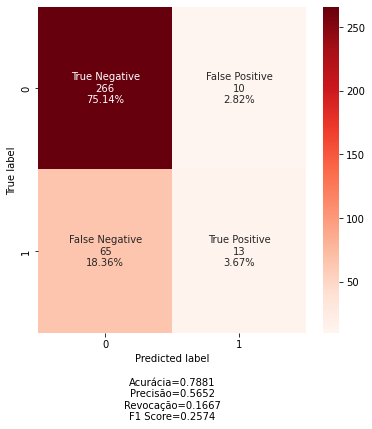

In [65]:
# instanciando modelo 'ml_SVC' de hiperparâmetros default
ml_SVC = SVC(probability=True, random_state=64)
print(ml_SVC)

# executando o treinamento do modelo
train_model(ml_SVC, X_train, y_train)

*********** Estatísticas da Base de Treinamento ************************

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       644
           1       0.62      0.16      0.26       182

    accuracy                           0.79       826
   macro avg       0.71      0.57      0.57       826
weighted avg       0.77      0.79      0.74       826

*********** Estatísticas da Base de Teste ******************************

              precision    recall  f1-score   support

           0       0.80      0.96      0.88       276
           1       0.57      0.17      0.26        78

    accuracy                           0.79       354
   macro avg       0.68      0.57      0.57       354
weighted avg       0.75      0.79      0.74       354



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



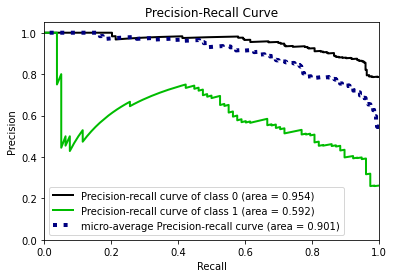

In [66]:
estat(ml_SVC, X_train, y_train)

In [45]:
counter = y_train.value_counts().to_numpy
print(counter)
print(X_train.info())


<bound method IndexOpsMixin.to_numpy of incompatibil
0               644
1               182
dtype: int64>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 826 entries, 1130 to 1135
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pais_de_origem_enc       826 non-null    int64  
 1   pais_de_aquisicao_enc    826 non-null    int64  
 2   unidade_desembaraco_enc  826 non-null    int64  
 3   incoterm_enc             826 non-null    int64  
 4   qtde_estatistica         826 non-null    float64
 5   vmle_dolar               826 non-null    float64
 6   vl_frete_dolar           826 non-null    float64
 7   vl_seguro_dolar          826 non-null    float64
 8   valor_un_prod_dolar      826 non-null    float64
 9   qtd_comercial            826 non-null    float64
 10  peso_liquido_rateado     826 non-null    float64
 11  valor_frete_rateado      826 non-null    float64
 12  seguro_rateado         

In [68]:
qtd = Counter(y_train['incompatibil'])
qtd

Counter({0: 644, 1: 182})

In [69]:
np.round(100*qtd[1]/qtd[0], 4)

28.2609

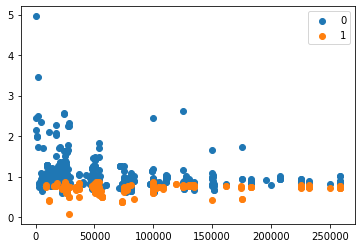

In [71]:
for label, _ in qtd.items():
	row_ix = np.where(y_train.values == label)[0]
	pyplot.scatter(X_train.values[row_ix, 4], X_train.values[row_ix, 14], label=str(label))
plt.legend()
plt.show()

In [76]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

In [77]:
oversample = BorderlineSMOTE()
X_train2, y_train2 = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [78]:
qtd2 = Counter(y_train2)
print(qtd2)

Counter({0: 644, 1: 644})


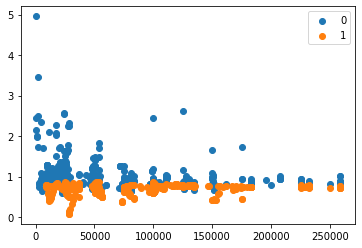

In [80]:
for label, _ in qtd2.items():
	row_ix = where(y_train2 == label)[0]
	pyplot.scatter(X_train2[row_ix, 4], X_train2[row_ix, 14], label=str(label))
plt.legend()
plt.show()

In [81]:
y_train2 = pd.DataFrame(y_train2)
X_train2 = pd.DataFrame(X_train2)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=64, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



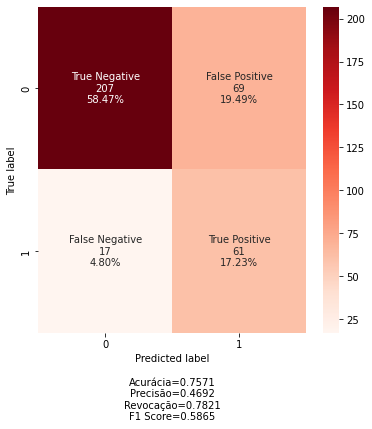

In [82]:
# instanciando modelo 'ml_SVC' de hiperparâmetros default
ml_SVC2 = SVC(probability=True, random_state=64)
print(ml_SVC2)

# executando o treinamento do modelo
train_model(ml_SVC2,X_train2,y_train2)

*********** Estatísticas da Base de Treinamento ************************

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       644
           1       0.77      0.79      0.78       644

    accuracy                           0.78      1288
   macro avg       0.78      0.78      0.78      1288
weighted avg       0.78      0.78      0.78      1288

*********** Estatísticas da Base de Teste ******************************

              precision    recall  f1-score   support

           0       0.92      0.74      0.82       276
           1       0.46      0.78      0.58        78

    accuracy                           0.75       354
   macro avg       0.69      0.76      0.70       354
weighted avg       0.82      0.75      0.77       354



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



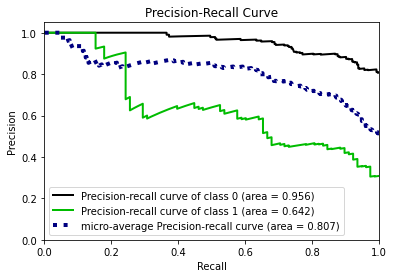

In [67]:
estat(ml_SVC2, X_train2, y_train2)